In [1]:
import pandas as pd
import numpy as np
import sys
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

# data clean

In [3]:
#replacing gender and age values which are not present to Nan
train.gender.replace('-unknown-',np.nan, inplace=True)
test.gender.replace('-unknown-',np.nan, inplace=True)
train.age.replace('NaN', np.nan, inplace=True)
test.age.replace('NaN',np.nan, inplace=True)

In [4]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,totalSec,totalAct,distance_km,booking
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,NaN,NaN,NaN,0
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,NaN,NaN,NaN,0
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,NaN,NaN,0.0,1
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,NaN,NaN,NaN,1
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,NaN,NaN,0.0,1


# Y

## 到達的國家

In [5]:
train.country_destination.value_counts() / train.shape[0] * 100

NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64

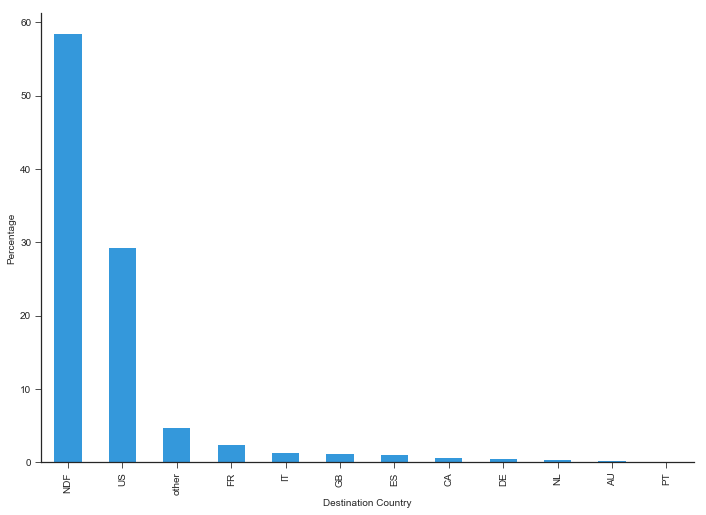

In [6]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
country_percentage = train.country_destination.value_counts() / train.shape[0] * 100
country_percentage.plot(kind='bar',color='#3498DB')
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

# X

## 性別

In [7]:
train.gender.value_counts() / train.shape[0] * 100

FEMALE    29.534179
MALE      25.504683
OTHER      0.132115
Name: gender, dtype: float64

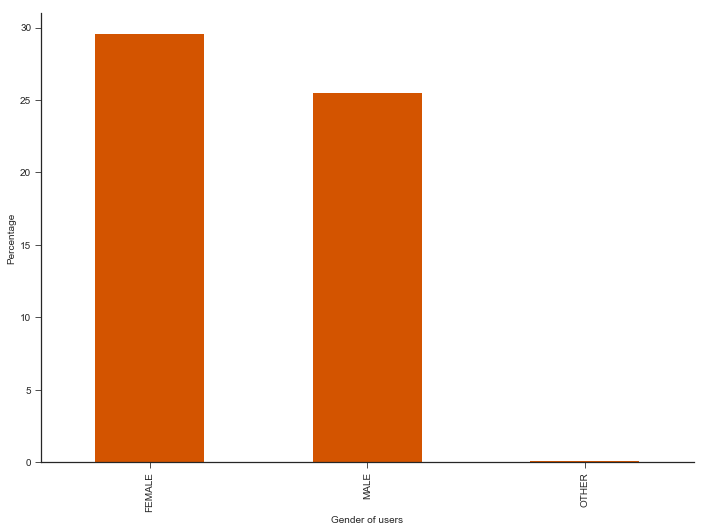

In [8]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
gender_percentage = train.gender.value_counts() / train.shape[0] * 100
gender_percentage.plot(kind='bar',color='#D35400')
plt.xlabel('Gender of users')
plt.ylabel('Percentage')
sns.despine()

## 年齡分段處理

In [9]:
age = train["age"]

In [10]:
age_test = test["age"]

In [11]:
age.fillna(-1, inplace = True) #缺值填入-1

In [12]:
age_test.fillna(-1, inplace = True) #缺值填入-1

In [13]:
div = 15 # 以15為一區間

In [14]:
def get_age(age):
    if age < 0:
        return 'NA' #表示是空值
    elif (age < div):
        return div #如果年龄小於15歲，那麼返回15歲
    elif (age <= div * 2):
        return div*2 #如果年龄大於15小於等於30歲，則返回30歲
    elif (age <= div * 3):
        return div * 3
    elif (age <= div * 4):
        return div * 4
    elif (age <= div * 5):
        return div * 5
    elif (age <= 110):
        return div * 6
    else:
        return 'Unphysical' #非正常年龄

In [15]:
train_x = pd.get_dummies(np.array([get_age(x) for x in age]), prefix = 'age')

In [16]:
test_x = pd.get_dummies(np.array([get_age(x) for x in age_test]), prefix = 'age')

## signup method

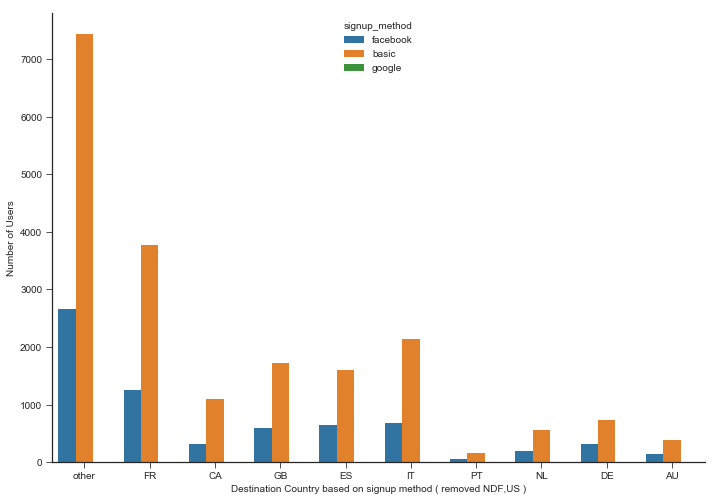

In [17]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
data_without_NDF = train[train['country_destination']!='US']
data_without_NDF1= data_without_NDF[data_without_NDF['country_destination']!='NDF']
sns.countplot(x='country_destination', hue='signup_method',data=data_without_NDF1)
plt.xlabel('Destination Country based on signup method ( removed NDF,US )')
plt.ylabel('Number of Users')
sns.despine()

## 找出date_account_created的年、月份、星期幾

In [18]:
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
test['date_account_created'] = pd.to_datetime(test['date_account_created'])

In [19]:
year_month_train = pd.concat((train.date_account_created.dt.year, train.date_account_created.dt.month), axis = 1)
year_month_test = pd.concat((test.date_account_created.dt.year, test.date_account_created.dt.month), axis = 1)

In [20]:
year_month_train.columns = ["year", "month"]
year_month_test.columns = ["year", "month"]

In [21]:
train_x = pd.concat((train_x, pd.get_dummies(train.date_account_created.dt.weekday_name, prefix = 'weekday')), axis = 1)
train_x = pd.concat((train_x, year_month_train), axis = 1)

In [22]:
test_x = pd.concat((test_x, pd.get_dummies(test.date_account_created.dt.weekday_name, prefix = 'weekday')), axis = 1)
test_x = pd.concat((test_x, year_month_test), axis = 1)

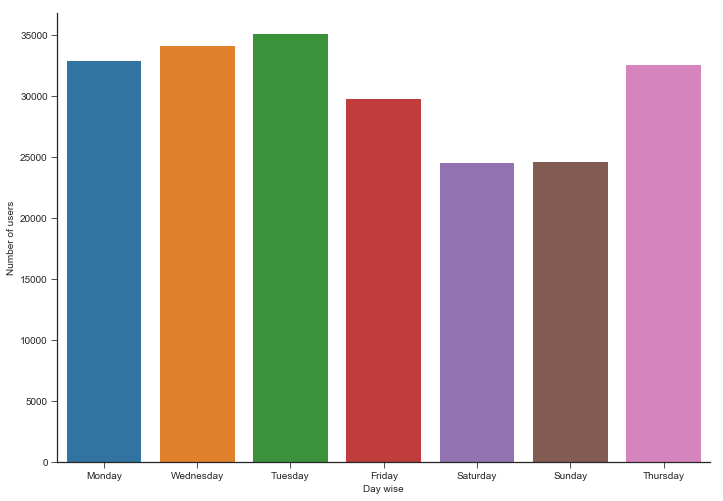

In [23]:
train['account_created_day'] = train.date_account_created.dt.weekday_name
train['account_created_month'] = train.date_account_created.dt.month
train['account_created_year'] = train.date_account_created.dt.year

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.countplot(x='account_created_day',data=train)
plt.xlabel('Day wise')
plt.ylabel('Number of users')
sns.despine()

## language

In [24]:
train.language.value_counts() / train.shape[0] * 100

en    96.656375
zh     0.764578
fr     0.549072
es     0.428670
ko     0.349963
de     0.342936
it     0.240805
ru     0.182243
pt     0.112438
ja     0.105411
sv     0.057156
nl     0.045444
tr     0.029983
da     0.027173
pl     0.025299
cs     0.014992
no     0.014055
th     0.011244
el     0.011244
id     0.010307
hu     0.008433
fi     0.006559
ca     0.002342
is     0.002342
hr     0.000937
Name: language, dtype: float64

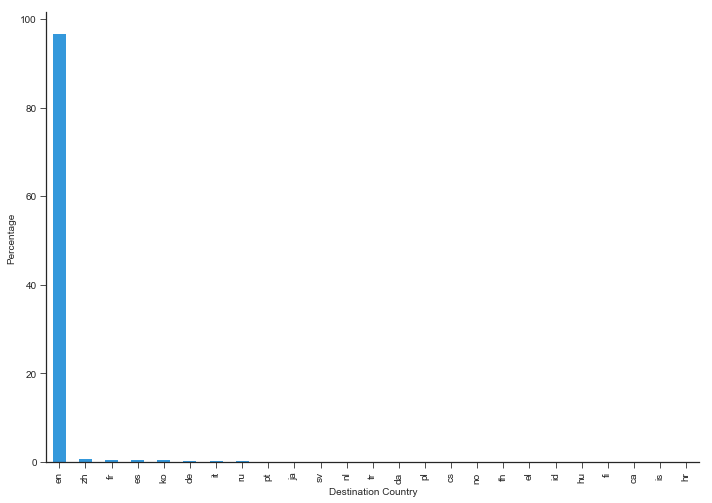

In [25]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
language_percentage = train.language.value_counts() / train.shape[0] * 100
language_percentage.plot(kind='bar',color='#3498DB')
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

## sign up app

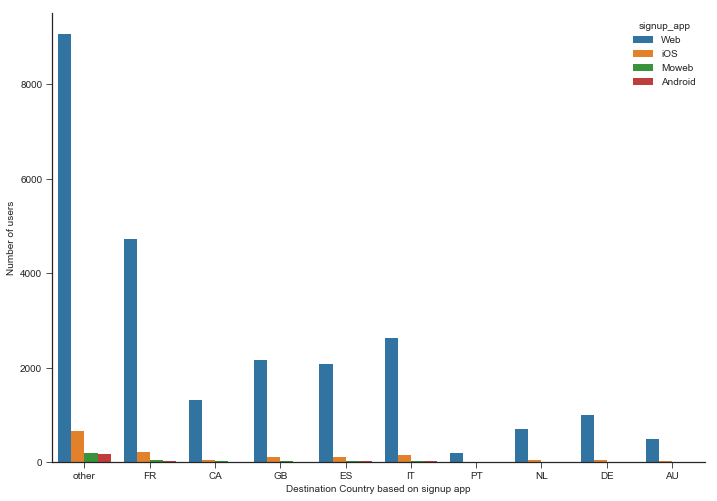

In [26]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
data_without_NDF = train[train['country_destination']!='US']
data_without_NDF1= data_without_NDF[data_without_NDF['country_destination']!='NDF']
sns.countplot(x='country_destination', hue='signup_app',data=data_without_NDF1)
plt.xlabel('Destination Country based on signup app')
plt.ylabel('Number of users')
sns.despine()

## first device type

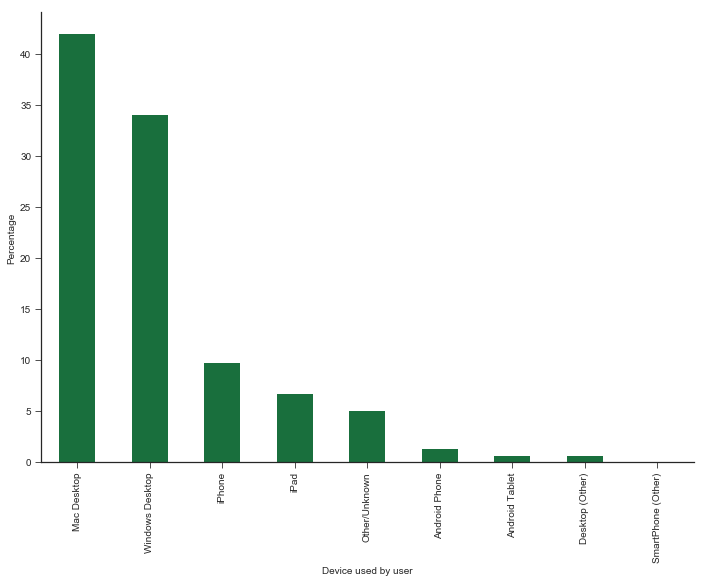

In [27]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
device_percentage = train.first_device_type.value_counts() / train.shape[0] * 100
device_percentage.plot(kind='bar',color='#196F3D')
plt.xlabel('Device used by user')
plt.ylabel('Percentage')
sns.despine()

## total sec分段處理

In [28]:
total_sec_train = train["totalSec"]
total_sec_test = test["totalSec"]

In [29]:
total_sec_train.fillna(0, inplace = True) #空值填充為0
total_sec_test.fillna(0, inplace = True)

In [30]:
train["totalSec"].describe()

count    213451.000000
mean       5236.483071
std       13358.536778
min           0.000000
25%           0.000000
50%           0.000000
75%        3060.500000
max      382214.000000
Name: totalSec, dtype: float64

In [31]:
test["totalSec"].describe()

count     62096.000000
mean      14503.373599
std       18654.337174
min           0.000000
25%        2562.000000
50%        8098.000000
75%       19356.250000
max      294695.000000
Name: totalSec, dtype: float64

In [32]:
def get_total_sec(sec):
    if sec == 0:
        return 'NA' #表示是空值
    elif (sec <= 3000):
        return 3000
    elif (sec <= 9000):
        return 9000
    else:
        return 'Unphysical'

In [33]:
train_x = pd.concat((train_x, pd.get_dummies(np.array([get_total_sec(x) for x in total_sec_train]), prefix = 'sec')), axis = 1)
test_x = pd.concat((test_x, pd.get_dummies(np.array([get_total_sec(x) for x in total_sec_test]), prefix = 'sec')), axis = 1)

## total act分段處理

In [34]:
total_act_train = train["totalAct"]
total_act_test = test["totalAct"]

In [35]:
total_act_train.fillna(0, inplace = True) #空值填充為0
total_act_test.fillna(0, inplace = True)

In [36]:
train["totalAct"].describe()

count    213451.000000
mean         25.944863
std          75.189408
min           0.000000
25%           0.000000
50%           0.000000
75%          15.000000
max        2644.000000
Name: totalAct, dtype: float64

In [37]:
test["totalAct"].describe()

count    62096.000000
mean        80.444537
std        112.314510
min          0.000000
25%         18.000000
50%         44.000000
75%         98.000000
max       2722.000000
Name: totalAct, dtype: float64

In [38]:
def get_total_act(act):
    if act == 0:
        return 'NA' #表示是空值
    elif (act <= 20):
        return 20
    elif (act <= 50):
        return 50
    elif (act <= 100):
        return 100
    else:
        return 'Unphysical'

In [39]:
train_x = pd.concat((train_x, pd.get_dummies(np.array([get_total_act(x) for x in total_act_train]), prefix = 'act')), axis = 1)
test_x = pd.concat((test_x, pd.get_dummies(np.array([get_total_act(x) for x in total_act_test]), prefix = 'act')), axis = 1)

# 其他特徵

## train與test資料對齊

In [40]:
test.signup_method.replace('weibo', np.nan, inplace=True)

In [41]:
def signup_flow(flow):
    if flow <= 8:
        return 8 #表示是空值
    elif (flow <= 12):
        return 12
    elif (flow <= 21):
        return 21
    elif (flow <= 23):
        return 23
    elif (flow <= 25):
        return 25

In [42]:
train["signup_flow"] = np.array([signup_flow(x) for x in train["signup_flow"]])
test["signup_flow"] = np.array([signup_flow(x) for x in test["signup_flow"]])

In [43]:
train.language.replace(['hr', 'is'], np.nan, inplace=True)
test.language.replace('-unknown-', np.nan, inplace=True)

In [44]:
train.affiliate_channel.replace("api", np.nan, inplace=True)

In [45]:
train.affiliate_provider.replace('wayn', np.nan, inplace=True)

In [46]:
train.first_browser.replace(['Arora', 'Avant Browser', 'Camino', 'Comodo Dragon', 'Conkeror', 'CoolNovo', 'Crazy Browser', 'Epic', 'Flock', 'Google Earth', 'Googlebot', 'IceDragon', 'Kindle Browser', 'Mozilla', 'NetNewsWire', 'OmniWeb', 'Outlook 2007', 'PS Vita browser', 'Palm Pre web browser', 'RockMelt', 'SlimBrowser', 'Stainless', 'TenFourFox', 'TheWorld Browser'], "other", inplace=True)
test.first_browser.replace(['IBrowse', 'Nintendo Browser', 'UC Browser'], "other", inplace=True)

## 進行one-hot-encoding處理

In [47]:
feat_toOHE = ['gender',
              'signup_method',
              'signup_flow',
              'language',
              'signup_app',
              'first_device_type',
              'affiliate_channel',
              'affiliate_provider',
              'first_browser']

In [48]:
for i in feat_toOHE:
    train_x = pd.concat((train_x, pd.get_dummies(train[i], prefix=i, dummy_na=True)), axis = 1)

In [49]:
for i in feat_toOHE:
    test_x = pd.concat((test_x, pd.get_dummies(test[i], prefix=i, dummy_na=True)), axis = 1)

## 對Y進行labels encoding

In [50]:
le = LabelEncoder()

In [51]:
np.unique(train.country_destination)

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

In [52]:
np.unique(le.fit_transform(train.country_destination))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [53]:
train_y = le.fit_transform(train.country_destination)

# 建立模型

## 切割訓練集0.8與驗證集0.2的資料

In [54]:
train_x.shape

(213451, 135)

In [55]:
train_y.shape

(213451,)

In [56]:
test_x.shape

(62096, 135)

In [57]:
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)

## xgboost模型

In [58]:
xgb = XGBClassifier()

In [59]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
print(xgb.score(x_test, y_test))

0.6331311049167272


C:\Users\Lee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [ ]:
trainDMatrix = xgb.DMatrix(trainData.as_matrix(),

                           label=trainLabels.astype(int))


validateDMatrix = xgb.DMatrix(validateData.as_matrix(),

                              label=validateLabels.astype(int))